In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [16]:
   # 1. .ipynb 파일 생성/열기
   # 2. 커널 선택에서 "Colab" 선택
   # 3. Google 계정 인증
   
   # GPU 확인
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


2025-03-27 19:51:22.628649: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144


Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 2)


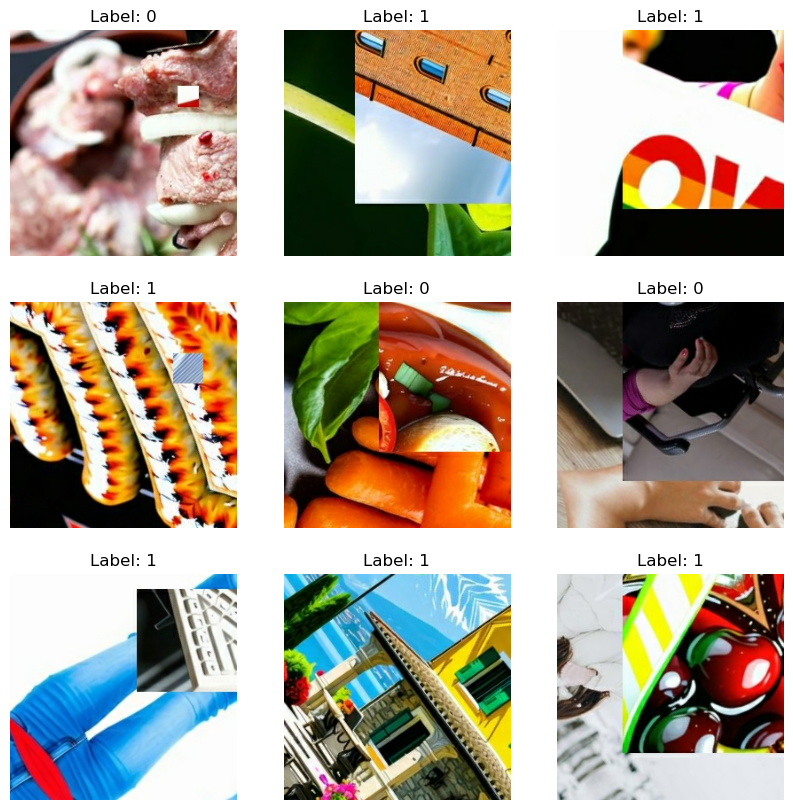


=== 데이터셋 통계 ===
전체 이미지 수: 63960

레이블 분포:
- 레이블 0: 31909개 (49.89%)
- 레이블 1: 32051개 (50.11%)

=== 이미지 특성 ===
이미지 shape: (256, 256, 3)
데이터 타입: <dtype: 'float32'>
최소값: 0.0
최대값: 1.0
평균값: 0.5803
표준편차: 0.3557


2025-03-27 19:51:48.218187: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
import tensorflow as tf
import os

# 경로 설정
DRIVE_PATH = "/content/drive/MyDrive/AIimg"
train_path = os.path.join(DRIVE_PATH, "swin_transformer_train.tfrecord")
val_path = os.path.join(DRIVE_PATH, "swin_transformer_val.tfrecord")

def parse_tfrecord(example_proto):
    """TFRecord 파일의 각 레코드를 파싱하는 함수"""
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([2], tf.float32)
    }
    
    features = tf.io.parse_single_example(example_proto, feature_description)
    
    image = tf.io.decode_jpeg(features['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, features['label']

def create_dataset(tfrecord_path, batch_size=32, is_training=True):
    """TFRecord 파일로부터 데이터셋 생성"""
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def count_samples_and_distribution(dataset):
    """데이터셋의 샘플 수와 레이블 분포를 계산"""
    total_samples = 0
    label_counts = {0: 0, 1: 0}  # 이진 분류를 가정
    
    for images, labels in dataset:
        batch_size = len(images)
        total_samples += batch_size
        
        # 레이블 카운트
        for label in labels:
            label_idx = int(tf.argmax(label))
            label_counts[label_idx] += 1
    
    return total_samples, label_counts

def print_dataset_info(dataset, name):
    """데이터셋 정보 출력"""
    print(f"\n=== {name} 데이터셋 정보 ===")
    
    # 샘플 수와 분포 계산
    total_samples, label_counts = count_samples_and_distribution(dataset)
    
    print(f"총 샘플 수: {total_samples}")
    print("\n레이블 분포:")
    for label, count in label_counts.items():
        percentage = (count / total_samples) * 100
        print(f"- 클래스 {label}: {count}개 ({percentage:.2f}%)")

def visualize_dataset(dataset, num_samples=5):
    """데이터셋 샘플 시각화"""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 3))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image[0])
        plt.title(f'Label: {tf.argmax(label[0])}')
        plt.axis('off')
    plt.show()

# 데이터셋 생성
BATCH_SIZE = 32
train_dataset = create_dataset(train_path, BATCH_SIZE, is_training=True)
val_dataset = create_dataset(val_path, BATCH_SIZE, is_training=False)

# 파일 정보 출력
print("\n파일 경로 및 크기:")
for path in [train_path, val_path]:
    size_mb = os.path.getsize(path) / (1024 * 1024)
    print(f"{os.path.basename(path)}: {size_mb:.2f}MB")

# 데이터셋 정보 출력
print_dataset_info(train_dataset, "훈련")
print_dataset_info(val_dataset, "검증")

# 샘플 시각화
print("\n훈련 데이터셋 샘플:")
visualize_dataset(train_dataset)
print("\n검증 데이터셋 샘플:")
visualize_dataset(val_dataset)

2025-03-27 19:51:48.478114: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


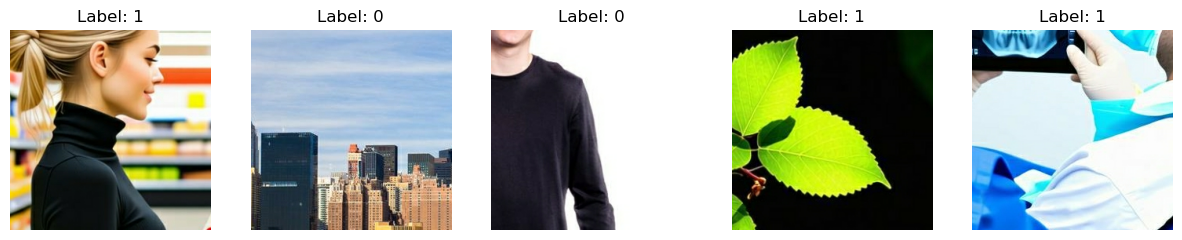


검증 데이터셋 통계:
전체 이미지 수: 15990
레이블 분포:
- 레이블 0: 7995개 (50.00%)
- 레이블 1: 7995개 (50.00%)


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Validation TFRecord 파일 경로
val_tfrecord_file = 'records/swin_transformer_val.tfrecord'

# TFRecord 파싱 함수
def _parse_function(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    
    # 이미지 디코딩
    image = tf.io.decode_jpeg(parsed_features['image'], channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0
    
    # 레이블
    label = parsed_features['label']
    
    return image, label

# Validation 데이터셋 로드
val_dataset = tf.data.TFRecordDataset(val_tfrecord_file)
val_dataset = val_dataset.map(_parse_function)

# 처음 몇 개의 이미지와 레이블 확인
plt.figure(figsize=(15, 5))
for i, (image, label) in enumerate(val_dataset.take(5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(image.numpy())
    plt.title(f'Label: {label.numpy()}')
    plt.axis('off')
plt.show()

# 데이터셋 통계 확인
total_images = 0
label_counts = {0: 0, 1: 0}

for _, label in val_dataset:
    label_counts[label.numpy()] += 1
    total_images += 1

print(f"\n검증 데이터셋 통계:")
print(f"전체 이미지 수: {total_images}")
print(f"레이블 분포:")
for label, count in label_counts.items():
    print(f"- 레이블 {label}: {count}개 ({count/total_images*100:.2f}%)")

##Define Model 


In [6]:
import tf_keras
print(tf_keras.__version__)

2.19.0


In [7]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [8]:
import torch
import torch.nn as nn
from transformers import AutoModelForImageClassification

# Load Swin Transformer model pre-trained on ImageNet
model_name = "microsoft/swinv2-base-patch4-window8-256"
model = AutoModelForImageClassification.from_pretrained(model_name, ignore_mismatched_sizes=True)

model.classifier = nn.Linear(model.classifier.in_features, 2)  # 2개의 클래스로 변경
#cpu is optinal. If you have a gpu, you can use it.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("✅ 분류 계층 교체 완료!")


/opt/anaconda3/envs/DLproject/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 분류 계층 교체 완료!


In [9]:
import torch
import tensorflow as tf
import numpy as np
from torch.utils.data import Dataset, DataLoader
# convert tfrecord to torch dataset, binary classification.
class SwinTFRDataset(Dataset):
    def __init__(self, tfrecord_path, transform=None):
        self.raw_dataset = list(tf.data.TFRecordDataset(tfrecord_path))  # ✅ 여기서 미리 리스트로 변환
        self.transform = transform

    def _parse_tfrecord(self, example_proto):
        feature_description = {
            "image": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.int64)
        }
        example = tf.io.parse_single_example(example_proto, feature_description)

        image = tf.io.decode_jpeg(example["image"], channels=3)
        image = tf.image.resize(image, (256, 256))
        image = tf.cast(image, tf.float32) / 255.0  # 정규화

        image = torch.tensor(image.numpy()).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
        
        label = torch.tensor(example["label"].numpy(), dtype=torch.long)
        return image, label

    def __len__(self):
        return len(self.raw_dataset)  #  고정된 길이를 반환

    def __getitem__(self, idx):
        raw_example = self.raw_dataset[idx]  # idx 기반으로 가져오기
        return self._parse_tfrecord(raw_example)




In [10]:
BATCH_SIZE = 32
#load datat set
train_dataset = SwinTFRDataset("records/swin_transformer_train.tfrecord")
val_dataset = SwinTFRDataset("records/swin_transformer_val.tfrecord")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

images, labels = next(iter(train_loader))
print(f"Train Image batch shape: {images.shape}")  # torch.Size([B, C, H, W])
print(f"Train Label batch shape: {labels.shape}")  # torch.Size([B])


2025-03-27 19:52:06.275856: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Image batch shape: torch.Size([32, 3, 256, 256])
Train Label batch shape: torch.Size([32])


In [11]:
from transformers import AutoModelForImageClassification
#load swin transformer model
model_name = "microsoft/swinv2-base-patch4-window8-256"
model = AutoModelForImageClassification.from_pretrained(
    model_name, num_labels=2, ignore_mismatched_sizes=True
)

# 
print(model)


Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0): Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=4, bias=False)
                  )
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128

In [12]:
import torch.nn as nn
import torch.optim as optim

# GPU setting (optional)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# setting the optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)


In [13]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
import os
import json

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3, device="cuda"):
    # 결과 저장을 위한 디렉토리 생성
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = f'training_results_{timestamp}'
    os.makedirs(save_dir, exist_ok=True)
    
    model.to(device)

    # 학습 기록을 위한 딕셔너리
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'epoch_times': [],
        'learning_rates': []
    }

    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        epoch_start_time = datetime.now()
        
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # 배치 진행상황 출력 (mini-batch loss 출력)
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs} | Batch: {batch_idx}/{len(train_loader)} | '
                    f'Mini-batch Loss: {loss.item():.4f}')

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(pixel_values=images).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total

        # 현재 학습률 저장
        current_lr = optimizer.param_groups[0]['lr']
        
        # 기록 저장
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)
        history['epoch_times'].append(
            (datetime.now() - epoch_start_time).total_seconds()
        )

        # 최고 성능 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{save_dir}/best_model.pth')

        # Epoch 결과 출력
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {current_lr}")
        print("-"*50)

    # 학습 완료 후 결과 저장
    # CSV 파일로 저장
    pd.DataFrame(history).to_csv(f'{save_dir}/training_history.csv', index=False)
    
    # 시각화 및 저장
    plt.figure(figsize=(15, 10))
    
    # 손실 그래프
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # 정확도 그래프
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(history['val_acc'], label='Validation Accuracy', marker='o')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    
    # 학습률 변화
    plt.subplot(2, 2, 3)
    plt.plot(history['learning_rates'], marker='o')
    plt.title("Learning Rate over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    
    # 에포크당 소요 시간
    plt.subplot(2, 2, 4)
    plt.plot(history['epoch_times'], marker='o')
    plt.title("Time per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Time (seconds)")
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/training_plots.png')
    plt.show()

    # 학습 설정 및 결과 요약 저장
    summary = {
        'best_val_accuracy': best_val_acc,
        'final_train_loss': train_loss,
        'final_val_loss': val_loss,
        'total_epochs': num_epochs,
        'total_training_time': sum(history['epoch_times']),
        'average_epoch_time': sum(history['epoch_times']) / len(history['epoch_times'])
    }
    
    with open(f'{save_dir}/training_summary.json', 'w') as f:
        json.dump(summary, f, indent=4)

    print(f"\nTraining completed. Results saved in {save_dir}")
    return history, model

In [14]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device=device)


Epoch: 1/5 | Batch: 0/1999 | Mini-batch Loss: 0.6986
Epoch: 1/5 | Batch: 10/1999 | Mini-batch Loss: 0.6545
Epoch: 1/5 | Batch: 20/1999 | Mini-batch Loss: 0.5983
Epoch: 1/5 | Batch: 30/1999 | Mini-batch Loss: 0.3404
Epoch: 1/5 | Batch: 40/1999 | Mini-batch Loss: 0.3549
Epoch: 1/5 | Batch: 50/1999 | Mini-batch Loss: 0.4111
Epoch: 1/5 | Batch: 60/1999 | Mini-batch Loss: 0.2983
Epoch: 1/5 | Batch: 70/1999 | Mini-batch Loss: 0.2354
Epoch: 1/5 | Batch: 80/1999 | Mini-batch Loss: 0.2297
Epoch: 1/5 | Batch: 90/1999 | Mini-batch Loss: 0.2403
Epoch: 1/5 | Batch: 100/1999 | Mini-batch Loss: 0.1470
Epoch: 1/5 | Batch: 110/1999 | Mini-batch Loss: 0.3911
Epoch: 1/5 | Batch: 120/1999 | Mini-batch Loss: 0.1531
Epoch: 1/5 | Batch: 130/1999 | Mini-batch Loss: 0.2021
Epoch: 1/5 | Batch: 140/1999 | Mini-batch Loss: 0.1812
Epoch: 1/5 | Batch: 150/1999 | Mini-batch Loss: 0.1805
Epoch: 1/5 | Batch: 160/1999 | Mini-batch Loss: 0.1998
Epoch: 1/5 | Batch: 170/1999 | Mini-batch Loss: 0.3645
Epoch: 1/5 | Batch: 1

KeyboardInterrupt: 